In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# update import path
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..', 'src'))

import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from importlib import reload
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split

# no warnings on dataframe slices
pd.options.mode.chained_assignment = None

In [48]:
# read csv
data = pd.read_csv(os.path.join('..', 'data', 'datasets', 'log.csv'), index_col=0)

# make datetime index (could also be done directly in read_csv)
data['datetime'] = pd.to_datetime(data['datetime'])
data = data.set_index('datetime')

print (data.shape)
data.head()

(190035, 9)


,angle_of_attack,boat_angle,boat_heel,boat_speed,course_error,rudder_angle,target_angle,wind_direction,wind_speed
datetime,,,,,,,,,
2018-11-14 08:57:45.722117,-6.808044,361.428205,2.088108,4.722192,-145.818080,0.0,145.776318,353.150193,17.507828
2018-11-14 08:57:45.772558,-6.940719,358.877005,2.160089,5.107827,-145.861282,0.0,145.776318,352.974317,17.765235
2018-11-14 08:57:45.811315,-6.273972,361.267334,1.959497,4.526222,-145.900472,0.0,145.776318,353.601874,17.819662
2018-11-14 08:57:45.846128,-6.160605,361.546447,1.990789,4.902556,-145.940287,-0.3,145.776318,353.675425,18.432092
2018-11-14 08:57:45.879947,-5.203338,359.726758,1.644039,4.445560,-145.945802,-0.6,145.776318,354.627178,18.014479


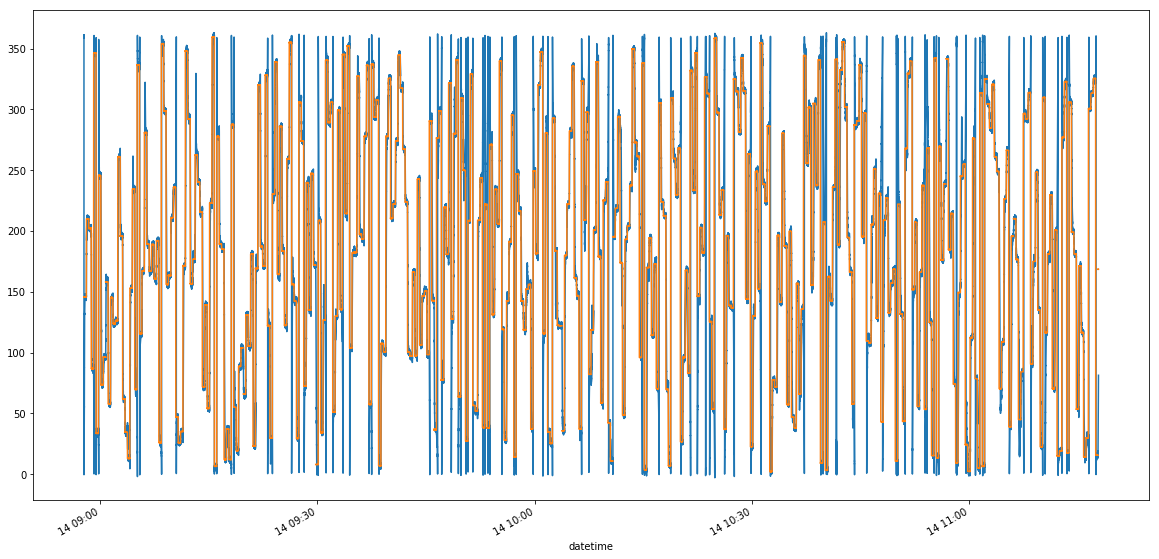

In [49]:
# show the boat approaching the target course
_, ax = plt.subplots(figsize=(20, 10))
data['boat_angle'].plot(ax=ax)
data['target_angle'].plot(ax=ax)

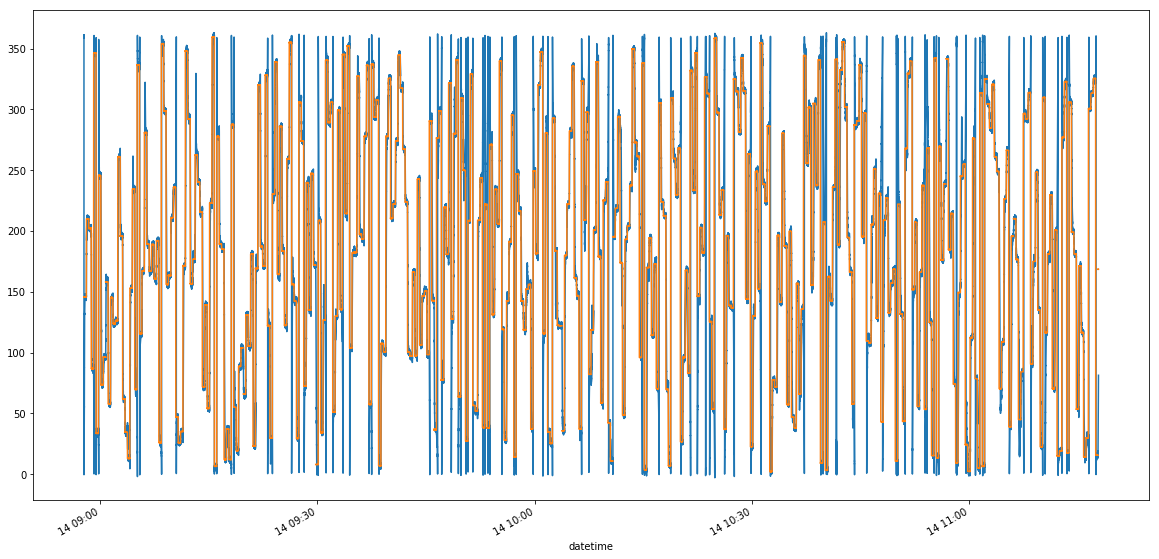

In [50]:
# remove data points with significant course error
data1 = data[data['course_error'].abs() < 2].reset_index()

# show again
_, ax = plt.subplots(figsize=(20, 10))
data['boat_angle'].plot(ax=ax)
data['target_angle'].plot(ax=ax)

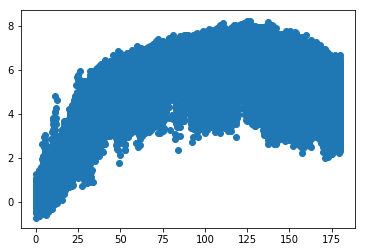

In [51]:
# scatter plot to show general shape of polar
data1['aoa_abs'] = data1['angle_of_attack'].abs()
plt.scatter(data1['aoa_abs'], data1['boat_speed'])

# start training

In [62]:
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

# select features and target
y = data1['boat_speed']
x = data1[['aoa_abs', 'wind_speed']]

# split test/train sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=42)

# train model
#model = LinearRegression()
#model = GradientBoostingRegressor(n_estimators=100)
model = make_pipeline(PolynomialFeatures(5), Ridge())

model.fit(x_train, y_train)

# show performance
pred_y = model.predict(x_test)
print ('MAE: ', mean_absolute_error(pred_y, y_test))

MAE:  0.33387220716140403


/Users/wouter/anaconda2/envs/aicaptain/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.054851e-27
  overwrite_a=True).T


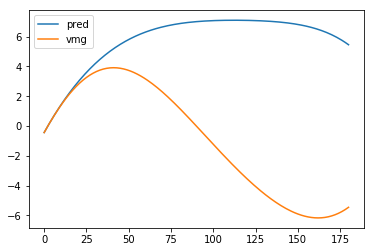

In [63]:
# function to predict boat speeds for all angles
def predict_boat_speeds(model, wind_speed):
    aoa = np.linspace(0, 180, 181)
    df = pd.DataFrame()
    df['aoa'] = aoa
    df['wind_speed'] = wind_speed
    df['pred'] = model.predict(df[['aoa', 'wind_speed']])
    df['vmg'] = df['pred'] * np.cos(np.radians((df['aoa'])))
    return df

# predict for 20 knots
df = predict_boat_speeds(model, 20)

# show predicted speed and vmg
plt.plot(df['aoa'], df['pred'])
plt.plot(df['aoa'], df['vmg'])
plt.legend()

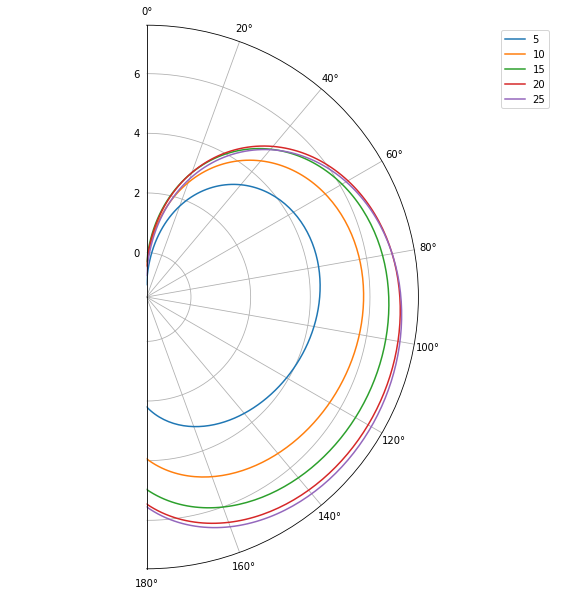

In [64]:
# show polar plot
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, polar=True)

for wind_speed in [5, 10, 15, 20, 25]:
    df = predict_boat_speeds(model, wind_speed)
    _ = ax.plot(np.radians(df['aoa']), df['pred'], label=wind_speed)

ax.set_thetamin(0)
ax.set_thetamax(180)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
plt.legend()
plt.show()

In [67]:
# predict tack and gybe angles for all wind speeds
data = pd.DataFrame()
for wind_speed in range(2, 50):
    df = predict_boat_speeds(model, wind_speed)
    row = {
        'wind_speed': wind_speed,
        'upwind_twa': df['vmg'].idxmax(),
        'downwind_twa': df['vmg'].idxmin(),
    }
    data = data.append([row])

# wind speed as index
data = data.set_index('wind_speed')

# save to file
data.to_pickle(os.path.join('..', 'src', 'strategies', 'my_strategy', 'angles.pkl'))

# show first rows
data

,downwind_twa,upwind_twa
wind_speed,,
2,0,44
3,151,43
4,153,42
5,155,42
6,157,41
7,158,41
8,159,41
9,159,41
10,160,40
